### <font color='red'>NOTE: Please do not edit this file. </font> Go to <font color='blue'>*File > Save a copy in Drive*</font>.

# **openHPI Course: Knowledge Graphs 2023**
## **Week 6: Intelligent Applications with Knowledge Graphs and Deep Learning**
### **Notebook 6.2: Link Prediction**

---


This is the second python notebook for week 6 (Intelligent Applications with Knowledge Graphs and Deep Learning) in the openHPI Course **Knowledge Graphs 2023**.

Please make a copy of this folder to your own machine and/or to your Google Drive.

# **Introduction to Knowledge Graph Completion using TransE**
In this tutorial, we perform a  Knowledge Graph completion task with the integrated **TransE** model from the Python library **AmpliGraph**. We will perform this task taking the following steps:

1. Installing libraries and loading a KG dataset
2. Training the TransE model
3. Evaluating the model
4. Predicting unknown relations







## **Installing libraries and loading a KG dataset**

**Mount your drive if you want to save the results**

In [ ]:
from google.colab import drive
import os
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/KG-Completion/'
os.mkdir(root_path)

Mounted at /content/gdrive


**Install the AmpliGraph library to use TransE**

In [ ]:
!pip install ampligraph==2.0.0;

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.3/178.3 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.5/575.5 kB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 74.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 531.9/531.9 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 4.7 MB

**Import numpy and pandas and check the version of AmpliGraph**

In [ ]:
import numpy as np
import pandas as pd
import ampligraph

ampligraph.__version__

'2.0.0'

**Load the Game of Thrones knowledge Graph**

In [ ]:
import requests
from ampligraph.datasets import load_from_csv

url = 'https://ampligraph.s3-eu-west-1.amazonaws.com/datasets/GoT.csv'
open('GoT.csv', 'wb').write(requests.get(url).content)
triples = load_from_csv('.', 'GoT.csv', sep=',')
triples[:5, ]

array([['Smithyton', 'SEAT_OF', 'House Shermer of Smithyton'],
       ['House Mormont of Bear Island', 'LED_BY', 'Maege Mormont'],
       ['Margaery Tyrell', 'SPOUSE', 'Joffrey Baratheon'],
       ['Maron Nymeros Martell', 'ALLIED_WITH',
        'House Nymeros Martell of Sunspear'],
       ['House Gargalen of Salt Shore', 'IN_REGION', 'Dorne']],
      dtype=object)

**Number of entities**

In [ ]:
entities = np.unique(np.concatenate([triples[:, 0], triples[:, 2]]))
entities.size

2050

**Number of relations**

In [ ]:
relations = np.unique(triples[:,1])
relations

array(['ALLIED_WITH', 'BRANCH_OF', 'FOUNDED_BY', 'HEIR_TO', 'IN_REGION',
       'LED_BY', 'PARENT_OF', 'SEAT_OF', 'SPOUSE', 'SWORN_TO'],
      dtype=object)

## **Training the TransE model**

**Split the dataset into train and test**

We need to make sure that all entities are represented in train and test sets by at least 1 triple. Ampligraph method ```train_test_split_no_unseen``` takes care of such a division.

In [ ]:
from ampligraph.evaluation import train_test_split_no_unseen

num_test = int(len(triples) * (20 / 100))

data = {}
data['train'], data['test'] = train_test_split_no_unseen(triples, test_size=num_test, seed=0, allow_duplication=False)

In [ ]:
print('Train set size: ', data['train'].shape)
print('Test set size: ', data['test'].shape)

Train set size:  (2540, 3)
Test set size:  (635, 3)


**Model Selection**

AmpliGraph 2 has a class for defining several Knoweldge Graph Embedding models (TransE, ComplEx, DistMult, HolE). Here we are going to use the TransE model.

In [ ]:
from ampligraph.latent_features import ScoringBasedEmbeddingModel

In [ ]:
# the embedding size is k,
# eta specifies the number of corruptions to generate per each positive,
# scoring_type determines the scoring function of the embedding model.
model = ScoringBasedEmbeddingModel(
                seed=0,
                k=150,
                eta=5,
                scoring_type = 'TransE')

In [ ]:
# Optimizer, loss and regularizer definition
from ampligraph.latent_features.loss_functions import get as get_loss
from ampligraph.latent_features.regularizers import get as get_regularizer
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=1e-3)
loss = get_loss('pairwise')
regularizer = get_regularizer('LP', {'p': 3, 'lambda': 1e-5})

# Compilation of the model
model.compile(loss=loss,
              optimizer=optimizer,
              verbose = True)

**Train the model**

In [ ]:
import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

model.fit(data['train'],
          batch_size= 100,
          epochs= 200,
          verbose = True)

Epoch 1/200
27/27 [==============================] - 2s 67ms/step - loss: 373.0594
Epoch 2/200
27/27 [==============================] - 0s 8ms/step - loss: 271.4373
Epoch 3/200
27/27 [==============================] - 0s 7ms/step - loss: 215.9040
Epoch 4/200
27/27 [==============================] - 0s 12ms/step - loss: 179.9356
Epoch 5/200
27/27 [==============================] - 0s 11ms/step - loss: 154.7953
Epoch 6/200
27/27 [==============================] - 0s 11ms/step - loss: 136.5949
Epoch 7/200
27/27 [==============================] - 0s 13ms/step - loss: 122.6390
Epoch 8/200
27/27 [==============================] - 0s 11ms/step - loss: 111.6643
Epoch 9/200
27/27 [==============================] - 0s 10ms/step - loss: 102.5508
Epoch 10/200
27/27 [==============================] - 0s 11ms/step - loss: 94.8753
Epoch 11/200
27/27 [==============================] - 0s 9ms/step - loss: 88.2369
Epoch 12/200
27/27 [==============================] - 0s 8ms/step - loss: 82.5562
Epoch 13

**Save the model**

In [ ]:
from ampligraph.utils import save_model, restore_model

In [ ]:
save_model(model, root_path + 'best_model.pkl')

**Get the Embeddings**

In [ ]:
from sklearn.decomposition import PCA

ent_embeddings = dict(zip(entities, model.get_embeddings(entities)))
embeddings_2d = PCA(n_components=2).fit_transform(np.array([i for i in ent_embeddings.values()]))

In [ ]:
from sklearn.cluster import KMeans
from ampligraph.discovery import find_clusters

# Cluster embeddings (on the original space)
clustering_algorithm = KMeans(n_clusters=6, n_init=100, max_iter=500, random_state=0)
clusters = find_clusters(entities, model, clustering_algorithm, mode='e')


**Visualize the Embeddings using T-SNE**

In [ ]:
!pip install adjustText

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 3.1 MB/s eta 0:00:00


In [ ]:
wellknownchars = ["House Lannister of Casterly Rock", "House Stark of Winterfell", \
                  "House Baratheon of King's Landing", "House Targaryen of King's Landing", \
                  "Jon Snow", "Daenerys Targaryen", "Drogo", "Sansa Stark", \
                  "Jaime Lannister", "Cersei Lannister", "Margaery Tyrell", \
                  "Joffrey Baratheon", "Jorah Mormont", "Brien of Tarth",
                  "Missandei", "Greyworm", "Sansa Stark", "Margaery Tyrell",
                  "Cateyn Stark", "Arya Stark"]

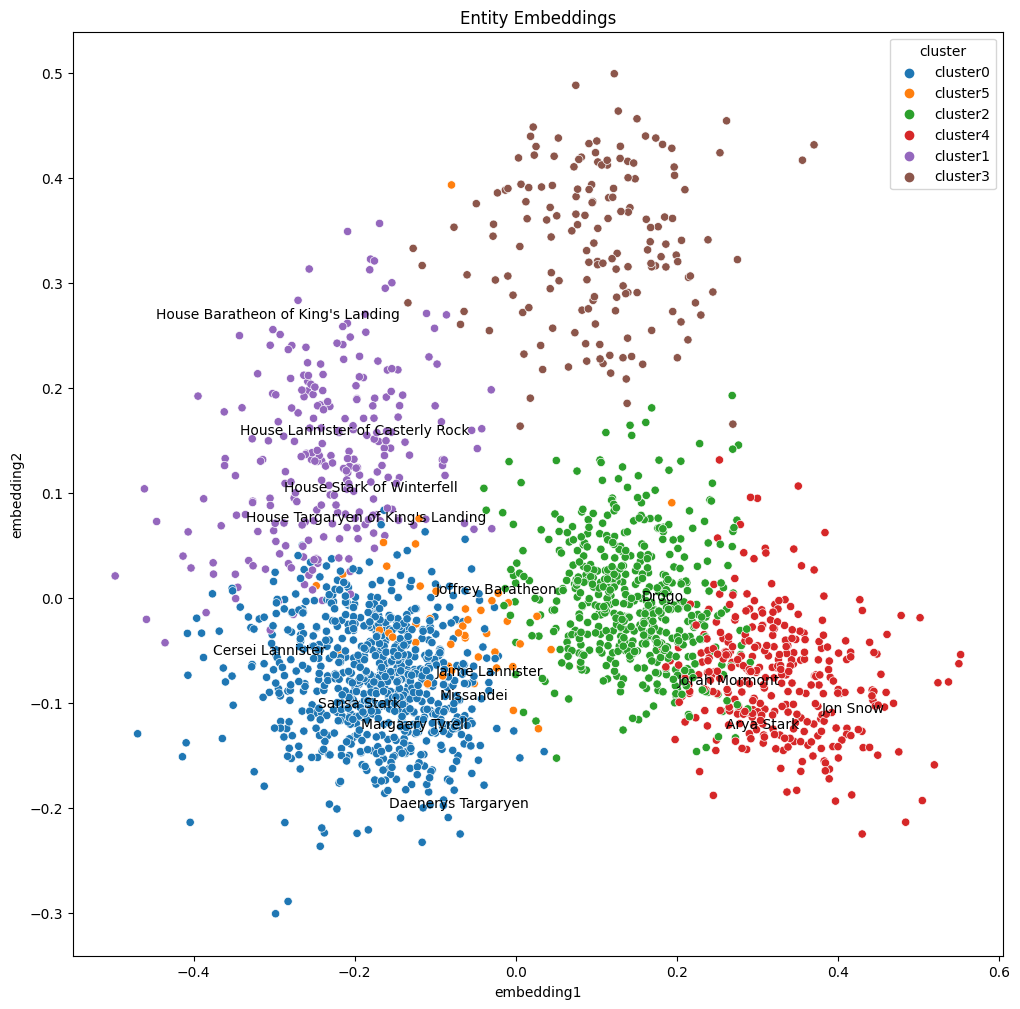

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

plot_df = pd.DataFrame({"characters": entities,
                        "embedding1": embeddings_2d[:, 0],
                        "embedding2": embeddings_2d[:, 1],
                        "cluster": "cluster" + pd.Series(clusters).astype(str)})

np.random.seed(0)


# Plot 2D embeddings with country labels
def plot_clusters(hue):
    plt.figure(figsize=(12, 12))
    plt.title("Entity Embeddings")
    ax = sns.scatterplot(data=plot_df[plot_df.characters != "unk"],
                         x="embedding1", y="embedding2", hue=hue)

    texts = []
    for i, point in plot_df.iterrows():
        if point["characters"] in wellknownchars:
        #if point["characters"] in wellknownchars or np.random.random() < 0.1:
            texts.append(plt.text(point['embedding1'] + 0.02,
                                  point['embedding2'] + 0.01,
                                  str(point["characters"])))
    adjust_text(texts)

plot_clusters("cluster")

## **Evaluating the model**

The **evaluation metrics** used are:

1. Mean Rank (MR) - measures the mean of a vector of rankings.
2. Mean Reciprocal Rank (MRR) - measures the mean of the reciprocal of elements of a vector of rankings. This is done to obtain a metric which is more robust to outliers.
3. Hits@N - measures how many elements of a vector of rankings make it to the top n positions.

**Filter negatives: Make sure no negative statements generated by the corruption procedure are actually positives**

In [ ]:
positives_filter = {'test': np.concatenate([data['train'], data['test']])}

**The ranks returned by the ```evaluate``` function indicate the rank at which the test set triple was found when performing link prediction using the model.**

In [ ]:
ranks = model.evaluate(data['test'],
                       use_filter = positives_filter,   # Corruption strategy filter defined above
                       corrupt_side = 's,o', # corrupt subj and obj separately while evaluating
                       verbose=True)

21/21 [==============================] - 4s 201ms/step


**Evaluation Metrics**



In [ ]:
from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score

mrr = mrr_score(ranks)
print("MRR: %.2f" % (mrr))

hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

MRR: 0.05
Hits@10: 0.12
Hits@3: 0.05
Hits@1: 0.02


## **Predicting unknown relations**

Link prediction allows us to infer missing links in a graph. We want to see which of the following triples are more likely to be true.

In [ ]:
X_unseen = np.array([
    ['Jorah Mormont', 'SPOUSE', 'Daenerys Targaryen'],
    ['Tyrion Lannister', 'SPOUSE', 'Missandei'],
    ["King's Landing", 'SEAT_OF', 'House Lannister of Casterly Rock'],
    ['Sansa Stark', 'SPOUSE', 'Petyr Baelish'],
    ['Daenerys Targaryen', 'SPOUSE', 'Jon Snow'],
    ['Daenerys Targaryen', 'SPOUSE', 'Craster'],
    ['House Stark of Winterfell', 'IN_REGION', 'The North'],
    ['House Stark of Winterfell', 'IN_REGION', 'Dorne'],
    ['House Tyrell of Highgarden', 'IN_REGION', 'Beyond the Wall'],
    ['Brandon Stark', 'ALLIED_WITH', 'House Stark of Winterfell'],
    ['Brandon Stark', 'ALLIED_WITH', 'House Lannister of Casterly Rock'],
    ['Rhaegar Targaryen', 'PARENT_OF', 'Jon Snow'],
    ['House Hutcheson', 'SWORN_TO', 'House Tyrell of Highgarden'],
    ['Daenerys Targaryen', 'ALLIED_WITH', 'House Stark of Winterfell'],
    ['Daenerys Targaryen', 'ALLIED_WITH', 'House Lannister of Casterly Rock'],
    ['Jaime Lannister', 'PARENT_OF', 'Myrcella Baratheon'],
    ['Robert I Baratheon', 'PARENT_OF', 'Myrcella Baratheon'],
    ['Cersei Lannister', 'PARENT_OF', 'Myrcella Baratheon'],
    ['Cersei Lannister', 'PARENT_OF', 'Brandon Stark'],
    ["Tywin Lannister", 'PARENT_OF', 'Jaime Lannister'],
    ["Missandei", 'SPOUSE', 'Grey Worm'],
    ["Brienne of Tarth", 'SPOUSE', 'Jaime Lannister']
])

In [ ]:
positives_filter['test'] = np.vstack((positives_filter['test'], X_unseen))

In [ ]:
ranks_unseen = model.evaluate(
    X_unseen,
    use_filter=positives_filter,   # Corruption strategy filter defined above
    corrupt_side = 's+o',
    verbose=True
)

2/2 [==============================] - 1s 474ms/step


In [ ]:
scores = model.predict(X_unseen)

To interpret the scores more intuitively, we transform the scores into probabilities (between 0 and 1) using the expit transform and explore the results with Pandas.

In [ ]:
from scipy.special import expit
probs = expit(scores)

In [ ]:
pd.DataFrame(list(zip([' '.join(x) for x in X_unseen],
                      ranks_unseen,
                      np.squeeze(scores),
                      np.squeeze(probs))),
             columns=['statement', 'rank', 'score', 'prob']).sort_values("rank")

,statement,rank,score,prob
17,Cersei Lannister PARENT_OF Myrcella Baratheon,[41],-13.669971,1.156662e-06
0,Jorah Mormont SPOUSE Daenerys Targaryen,[56],-12.092899,5.599099e-06
12,House Hutcheson SWORN_TO House Tyrell of Highg...,[59],-14.532384,4.882763e-07
6,House Stark of Winterfell IN_REGION The North,[262],-14.240551,6.537429e-07
9,Brandon Stark ALLIED_WITH House Stark of Winte...,[263],-14.581972,4.646541e-07
2,King's Landing SEAT_OF House Lannister of Cast...,[626],-14.639732,4.385760e-07
20,Missandei SPOUSE Grey Worm,[664],-15.030547,2.966991e-07
19,Tywin Lannister PARENT_OF Jaime Lannister,[950],-15.756633,1.435427e-07
7,House Stark of Winterfell IN_REGION Dorne,[1104],-14.261747,6.400318e-07
18,Cersei Lannister PARENT_OF Brandon Stark,[1139],-15.352951,2.149305e-07
